# Code Handout - Assignment 5 - Ball and Beam
## Solution

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## TODO:

Relevant matlab files:

- `BallAndBeamSymbolicTemplate.m` -- symbolic calculations for task 1e, should be completed by the student
- `BallAndBeamODEMatrices.m` -- routine used in the state-space model together with the PD-law, backbone for full model which the student should make
- `BallAndBeamSimulation.m` -- optional, should be completed by the student

Critical

- Make the symbolic template, this is most of the code work
- ???

In [20]:
import sympy as sm
from sympy import vector
from IPython.display import display_latex

# Defining the necessary symbols

J, M, R, g, To = sm.symbols("J M R g T_o")
x, theta = sm.symbols("x theta")
dx = x.diff()
dtheta = theta.diff()
dx, dtheta = sm.symbols("dx d\\theta")

q = sm.Matrix((x, theta))
dq = sm.Matrix((dx, dtheta))

p = x * sm.Matrix([sm.cos(theta), sm.sin(theta)])\
    + R * sm.Matrix([-sm.sin(theta), sm.cos(theta)])

linear_energy_beam = 0.5 * J * dtheta**2

dp = sm.Matrix.jacobian(p, q)
linear_energy_ball = (0.5 * M * (dq.T @ (dp.T @ dp) @ dq))[0, 0]

I = (2/5) * M * R**2
omega = dtheta + dx / R

rotational_energy_ball = 0.5 * I * omega**2

T = sm.simplify(linear_energy_beam + rotational_energy_ball + linear_energy_ball)

V = M * g * p[1]

Lagrangian = sm.Matrix([T - V])

Lagrangian_q = sm.simplify(sm.Matrix.jacobian(Lagrangian, q))
Lagrangian_qdq = sm.simplify(sm.Matrix.jacobian(Lagrangian_q, dq))
Lagrangian_dq = sm.simplify(sm.Matrix.jacobian(Lagrangian, dq))
Lagrangian_dqdq = sm.simplify(sm.Matrix.jacobian(Lagrangian_dq, dq))

W = Lagrangian_dqdq
RHS = sm.Matrix([0, To]) + sm.simplify(Lagrangian_q.T - Lagrangian_qdq @ dq)

state = sm.Matrix([q, dq])
param = sm.Matrix([J, M, R, g])


In [21]:
display_latex(q)
display_latex(dq)
display_latex(p)

In [22]:
display_latex(linear_energy_beam)
display_latex(dp)
display_latex(sm.simplify(linear_energy_ball))

In [23]:
display_latex(I)
display_latex(omega)
display_latex(rotational_energy_ball)

In [24]:
display_latex(sm.expand(T))
display_latex(V)
display_latex(Lagrangian)

In [25]:
display_latex(Lagrangian_q)
display_latex(Lagrangian_dq)
display_latex(Lagrangian_qdq)
display_latex(Lagrangian_dqdq)

In [26]:
display_latex(W)
display_latex(RHS)

In [27]:
lol = sm.lambdify((state, param), p, modules="numpy")
ball_position = sm.lambdify((state, param), p, modules="numpy")
get_W = sm.lambdify((state, param, To), W, modules="numpy")
get_RHS = sm.lambdify((state, param, To), RHS, modules="numpy")

In [28]:
display_latex(p)
print(ball_position((1, 0, 0, 0), (0, 0, 1, 0)))

[[1.]
 [1.]]


In [29]:
display_latex(W)
print(get_W((0, 0, 0, 0), (1, 1, 1, 0), 0))

[[ 1.4 -0.6]
 [-0.6  2.4]]


In [30]:
display_latex(RHS)
print(get_RHS((1, 0, 0, 1), (0, 1, 1, 1), 0))

[[-1.]
 [-1.]]


### Simulation

In [113]:
from scipy.integrate import solve_ivp

# Parameters and initial states
time_final  = 15
_J, _M, _R, _g = 1, 10, .25, 9.81
parameters = np.array([_J, _M, _R, _g])
_x, _th, _dx, _dth = 1, 1, 0, 0
state = np.array([_x, _th, _dx, _dth])

def make_ball_and_beam_dynamics(param):
    def ball_and_beam_dynamics(time, state):
        T = 200 * (state[0] - state[1]) + 70 * (state[2] - state[3])
        W = get_W(state, param, T)
        RHS = get_RHS(state, param, T)
        acc = np.linalg.inv(W) @ RHS
        return np.hstack(([state[2], state[3]], acc.reshape(2,)))
    return ball_and_beam_dynamics
    

In [114]:
dyn = make_ball_and_beam_dynamics(parameters)

In [115]:
dyn(0, state)

array([ 0.        ,  0.        , -6.27323766, -3.51801573])

In [116]:
res = solve_ivp(dyn, (0, time_final), state)
res.y.shape

(4, 134)

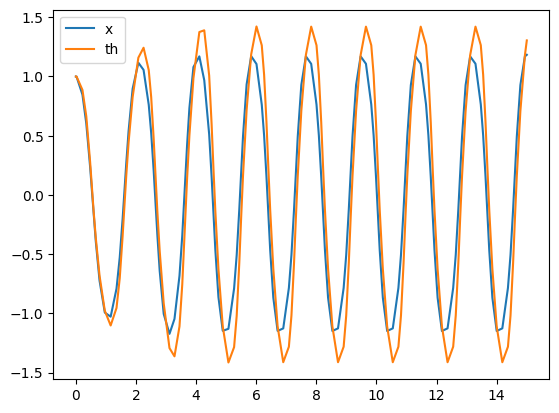

In [117]:
plt.plot(res.t, res.y[0, :], label="x")
plt.plot(res.t, res.y[1, :], label="th")
plt.legend()
plt.show()

In [118]:
ball_pos = np.zeros((3, res.y.shape[1]))
ball_pos[0, :] = res.y[0, :]
ball_pos[1, :] = (.25+0.05) * np.ones((len(res.t)))

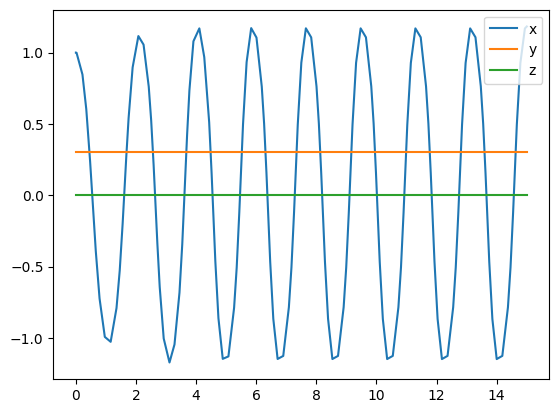

In [119]:
plt.plot(res.t, ball_pos[0, :], label="x")
plt.plot(res.t, ball_pos[1, :], label="y")
plt.plot(res.t, ball_pos[2, :], label="z")
plt.legend()
plt.show()

In [120]:
from scipy.spatial.transform import Rotation as R

beam_rot = R.from_euler("z", res.y[1, :], degrees=True).as_quat()

In [121]:
beam_rot.flatten()

array([ 0.00000000e+00,  0.00000000e+00,  8.72653550e-03,  9.99961923e-01,
        0.00000000e+00,  0.00000000e+00,  8.72653491e-03,  9.99961923e-01,
        0.00000000e+00,  0.00000000e+00,  8.72646359e-03,  9.99961924e-01,
        0.00000000e+00,  0.00000000e+00,  8.71898996e-03,  9.99961989e-01,
        0.00000000e+00,  0.00000000e+00,  7.73373176e-03,  9.99970094e-01,
        0.00000000e+00,  0.00000000e+00,  5.79934509e-03,  9.99983184e-01,
        0.00000000e+00,  0.00000000e+00,  2.46520195e-03,  9.99996961e-01,
        0.00000000e+00,  0.00000000e+00,  5.79990255e-04,  9.99999832e-01,
        0.00000000e+00,  0.00000000e+00, -1.24570555e-03,  9.99999224e-01,
        0.00000000e+00,  0.00000000e+00, -3.16963941e-03,  9.99994977e-01,
        0.00000000e+00,  0.00000000e+00, -5.95551895e-03,  9.99982266e-01,
        0.00000000e+00,  0.00000000e+00, -8.53289861e-03,  9.99963594e-01,
        0.00000000e+00,  0.00000000e+00, -9.61491136e-03,  9.99953776e-01,
        0.00000000e+00,  

In [122]:
import pythreejs as pj

folder = "space_cubemap"
texture_paths = [
    f"../figures/{folder}/px.png",  # Positive X
    f"../figures/{folder}/nx.png",  # Negative X
    f"../figures/{folder}/py.png",  # Positive Y
    f"../figures/{folder}/ny.png",  # Negative Y
    f"../figures/{folder}/pz.png",  # Positive Z
    f"../figures/{folder}/nz.png",  # Negative Z
]

scene = pj.Scene()
camera = pj.PerspectiveCamera(position=[0, 0, 5], up=[0, 1, 0], aspect=1)
camera.lookAt([0, 0, 0])

box_sides = 500
geom = pj.BoxGeometry(width=box_sides, height=box_sides, depth=box_sides)
materials = []
for path in texture_paths:
    texture = pj.ImageTexture(imageUri=path)
    material = pj.MeshBasicMaterial(map=texture, side='BackSide')
    materials.append(material)

skybox = pj.Mesh(geom, materials)
scene.add(skybox)


ball = pj.Mesh(
    pj.SphereGeometry(.25, 32, 16),
    pj.MeshStandardMaterial(color="blue")
)
beam = pj.Mesh(
    pj.BoxGeometry(2, .1, .5),
    pj.MeshStandardMaterial(color="red")
)

beam.position = (0, 0, 0)
ball.position = tuple(ball_pos[:, 0])

pivot = pj.Group()
pivot.add(beam)
pivot.add(ball)

scene.add(pivot)

#ball_pos = np.zeros_like(ball_pos)
#ball_pos[0, :] = res.y[0, :]
#ball_pos[1, :] = 1 * np.ones((len(res.t)))

ball_position_track = pj.VectorKeyframeTrack(name=".children[1].position", times = res.t, values = ball_pos.T)
pivot_rotation_track = pj.QuaternionKeyframeTrack(name=".quaternion", times = res.t, values = beam_rot)
ball_clip = pj.AnimationClip(tracks=[ball_position_track])
ball_action = pj.AnimationAction(pj.AnimationMixer(ball), ball_clip, ball)

#pivot_position_track = pj.VectorKeyframeTrack(name=".position", times = time, values = positions)
#pivot_rotation_track = pj.QuaternionKeyframeTrack(name = ".quaternion", times = time, values = rotations)
pivot_clip = pj.AnimationClip(tracks = [ball_position_track, pivot_rotation_track])
pivot_action = pj.AnimationAction(pj.AnimationMixer(pivot), pivot_clip, pivot)

print(pivot.children)

view_width, view_height = 800, 600
camera = pj.PerspectiveCamera(position=[5, 3, 5], aspect = view_width/view_height)
ambient_light = pj.AmbientLight(color="#ffffff", intensity=1.0)
key_light = pj.DirectionalLight(position=[0, 10, 0])
scene.add(ambient_light)
scene.add(key_light)

renderer = pj.Renderer(camera=camera, scene=scene, width=view_width, height=view_height)
controls = pj.OrbitControls(controlling = camera)
renderer.controls = [controls]

display(renderer)
pivot_action
#ball_action


(Mesh(geometry=BoxGeometry(depth=0.5, height=0.1, width=2.0), material=MeshStandardMaterial(alphaMap=None, aoMap=None, bumpMap=None, color='red', defines={'STANDARD': ''}, displacementMap=None, emissiveMap=None, envMap=None, lightMap=None, map=None, metalnessMap=None, normalMap=None, normalScale=(1.0, 1.0), roughnessMap=None), position=(0.0, 0.0, 0.0), quaternion=(0.0, 0.0, 0.0, 1.0), rotation=(0.0, 0.0, 0.0, 'XYZ'), scale=(1.0, 1.0, 1.0), up=(0.0, 1.0, 0.0)), Mesh(geometry=SphereGeometry(heightSegments=16, radius=0.25, widthSegments=32), material=MeshStandardMaterial(alphaMap=None, aoMap=None, bumpMap=None, color='blue', defines={'STANDARD': ''}, displacementMap=None, emissiveMap=None, envMap=None, lightMap=None, map=None, metalnessMap=None, normalMap=None, normalScale=(1.0, 1.0), roughnessMap=None), position=(1.0, 0.3, 0.0), quaternion=(0.0, 0.0, 0.0, 1.0), rotation=(0.0, 0.0, 0.0, 'XYZ'), scale=(1.0, 1.0, 1.0), up=(0.0, 1.0, 0.0)))


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(5.0, 3.0, 5.0), projectionMatrix=(1.0, …

AnimationAction(clip=AnimationClip(tracks=(VectorKeyframeTrack(name='.children[1].position', times=array([0.00…

In [95]:
pivot.children[1]

Mesh(geometry=SphereGeometry(heightSegments=16, radius=0.25, widthSegments=32), material=MeshStandardMaterial(…